# CSCI587 - Assignment \#2

The objective of this assignment is to design and implement an in memmory spatial network index structure that is used in Spatial Network Databases (SNDB), following the framework presented in this paper: [Link to paper.](https://www.vldb.org/conf/2003/papers/S24P02.pdf)
To test and evaluate the performance of the index structure, you will need to implement the spatial nearest neighbor queries following the Incremental Euclidean Restriction (IER) and Incremental Network Expansion (INE) methods.

In the following you will be given step-by-step instructions on how to implement these. Your task is to filling in the missing parts as indicated by `
``### ADD YOUR CODE HERE``. Ensure the code is well-documented and follows the structure provided.

In [1]:
### Install dependencies
!pip install geopandas
!pip install osmnx
!pip install rtree

## Step 1- Download the POI and Road-Network Data for San Francisco Area

For this assignment, we will use Point-of-Interest data and the underlying road network of San Fransisco City as provided by OpenStreat Map (OSM). The POI data includes various locations such as restaurants, hotels, and landmarks, while the road network represents the streets and intersections of the city.

This step is already implemented for you. You will need to run the following cells to download and store the data.


#### Download the Road Network data

We download the road network of San Fransisco using the osmnx package.

/tmp/ipykernel_1865430/2934351518.py:12: FutureWarning: The `save_graph_shapefile` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.save_graph_shapefile(G)
/home/users/bita/anaconda3/envs/pyg/lib/python3.10/site-packages/osmnx/io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


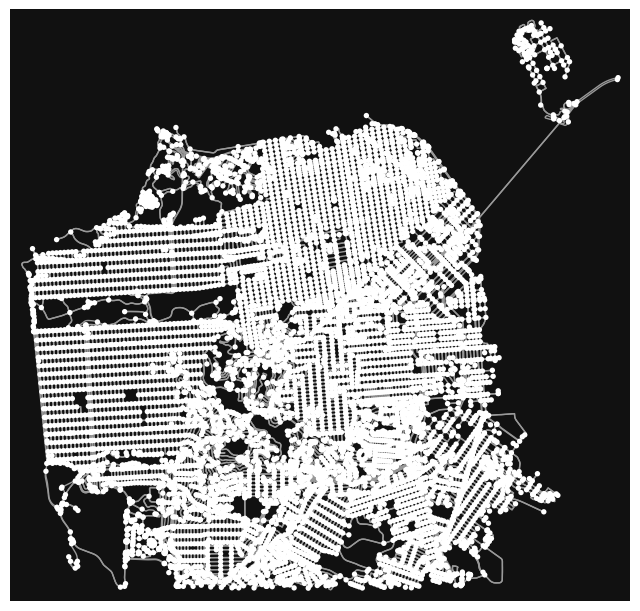

Nodes columns: Index(['y', 'x', 'street_count', 'ref', 'highway', 'geometry'], dtype='object')
Edges columns: Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'tunnel', 'geometry', 'access',
       'junction', 'width'],
      dtype='object')


In [5]:
import osmnx as ox
import geopandas as gpd
import os

# Download data if not already stored
if not os.path.exists('sf-road_network.graphml'):

  # Specify area as San Francisco, CA
  G = ox.graph_from_place('San Francisco, California, USA', network_type='drive', simplify=True) # set to simplify=True for a less nodes

  # Save the graph
  ox.save_graph_shapefile(G)
  ox.save_graphml(G, filepath='sf-road_network.graphml')

else:

  # Load data from the file
  G = ox.load_graphml('sf-road_network.graphml')

# Plot the road network
ox.plot_graph(G)
  
# Extract the nodes and edges from the graph
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

print("Nodes columns:", nodes_gdf.columns)
print("Edges columns:", edges_gdf.columns)

#### Download the POI data for San Francisco Area

Here, we make sure that the POIs are within the road network bounding box.

From this part of the code you will obtain an ``attractions_gdf`` dataframe that holds all POIs of San Francisco.

In [6]:
from shapely.geometry import box

# Check if data is already stored
if not os.path.exists('sf-attractions.geojson'):

  tags = {'tourism': True, 'amenity': True}

  # Load tourist attractions in San Francisco
  attractions = ox.features.features_from_place('San Francisco, California, USA', tags)

  # Plot the tourist attractions
  attractions = attractions[['name', 'geometry']]
  attractions_gdf = gpd.GeoDataFrame(attractions, geometry='geometry')
  print("Number of POIs before bounding box:", len(attractions_gdf))
  # Get the bounding box of the road network
  minx, miny, maxx, maxy = edges_gdf.total_bounds

  # Create a bounding box polygon
  bounding_box = box(minx, miny, maxx, maxy)

  # Convert the bounding box to a GeoDataFrame
  bounding_box_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'], crs=edges_gdf.crs)

  # Ensure the POIs and road network have the same Coordinate Reference System
  if attractions_gdf.crs != edges_gdf.crs:
      attractions_gdf = attractions_gdf.to_crs(edges_gdf.crs)

  # Filter the POIs to keep only those within the bounding box
  attractions_in_bbox = attractions_gdf[attractions_gdf.within(bounding_box)]

  # Drop non-Point geometries
  attractions_in_bbox = attractions_in_bbox[attractions_in_bbox.geom_type == 'Point']

  # Add x and y coordinates as seperate columns
  attractions_in_bbox['x'] = attractions_in_bbox.geometry.x
  attractions_in_bbox['y'] = attractions_in_bbox.geometry.y

  # Reset index
  attractions_in_bbox = attractions_in_bbox.reset_index(drop=True)

  # Save attractions
  attractions_in_bbox.to_file('sf-attractions.geojson', driver='GeoJSON')


# Load data from the file
attractions_gdf = gpd.read_file('sf-attractions.geojson')

# Reset index
attractions_gdf = attractions_gdf.reset_index(drop=True)

# Plot dataframe
print("Column names in dataframe:", attractions_gdf.columns)
print("Number of POIs:", len(attractions_gdf))

Number of POIs before bounding box: 20075
Column names in dataframe: Index(['name', 'x', 'y', 'geometry'], dtype='object')
Number of POIs: 14201


In [3]:
attractions_gdf

,name,x,y,geometry
0,Woods Lowside,-122.431015,37.772145,POINT (-122.43102 37.77214)
1,Toronado,-122.431222,37.771910,POINT (-122.43122 37.77191)
2,Molotov's,-122.431762,37.772054,POINT (-122.43176 37.77205)
3,Noc Noc,-122.431419,37.771889,POINT (-122.43142 37.77189)
4,Danny Coyles,-122.433264,37.771865,POINT (-122.43326 37.77186)
...,...,...,...,...
14196,None,-122.418884,37.797693,POINT (-122.41888 37.79769)
14197,None,-122.418869,37.797654,POINT (-122.41887 37.79765)
14198,None,-122.427929,37.792249,POINT (-122.42793 37.79225)
14199,The Sea Star,-122.388414,37.760744,POINT (-122.38841 37.76074)


## Part 2- Index Creation

**Time to code!** In this part you will be asked to create the following index structures:

  1.   An R-tree index that stores the POI data

  2.   A network Storage Scheme consisting of the following 3 components
    
    i. Adjacency component, to represent the network connectivity
    
    ii. The poly-line component, to store the the poly-line representation of each segment in the network
    
    iii. An R-tree index that indexes the polylines.




#### Part 2.1. Create an R-Tree index for POI data.

For this part you can use the built in python library rtree.

In [3]:
from rtree import index

# For accurate distance calculations, we project geometris to EPSG:32610 coordinate system.
attractions_gdf = attractions_gdf.to_crs(epsg=32610)

# Build R-tree index for POIs
poi_rtree = index.Index()
for idx, row in attractions_gdf.iterrows():
    # ADD YOUR CODE HERE
    poi_rtree.insert(idx, row.geometry.bounds)

#### Part 2.2.a: Create the adjacency component to represent the network connectivity

Step 1: Define Node Adjacency Entry. In this part you will need to create a node entry. For each node, you will need to store:
 - NBptr: Pointer to the neighbor's adjacency list.
 - distance: Network distance between the current node and the neighbor.
 - MBR: The bounding box (MBR) of the road segment (or edge) between the nodes.
 - PLptr: Pointer to the poly-line data that represents the actual geometry of the road segment.

**Example:** Assuming an edge $e_1$ between two nodes $n_1$ and $n_2$. These nodes are neighbors. An Adjacency Entry for node $n_1$ should hold: A pointer to the adjacency list of $n_2$. The distance between $n_1$ and $n_2$ the MBR of $e_1$ and a pointer to the actual geometry of $e_1$.

In [4]:
### YOUR CODE HERE: Define the node adjacency entry.

### Hint: You can represent this as a class.
class NodeAdjacency:
    def __init__(self, NBptr=None, distance=None, MBR=None, PLptr=None):
        self._NBptr = NBptr
        self._distance = distance
        self._MBR = MBR
        self._PLptr = PLptr
        
    def __str__(self):
        return f"distance: {self._distance}, MBR: {self._MBR}, PLptr: {self._PLptr}"
    def __repr__(self):
        return f"distance: {self._distance}, MBR: {self._MBR}, PLptr: {self._PLptr}"

Step 2: Define Node Representation. Now, each node in the network will have an adjacency list that holds multiple AdjacencyEntry objects, representing their neighbors.

In [5]:
### YOUR CODE HERE: Define the node representation

from shapely.geometry import Point

# For accurate distance calculations, we project geometris to EPSG:32610 coordinate system.
nodes_gdf = nodes_gdf.to_crs(epsg=32610) # Roads and road intersections are represented as edges and nodes, respectively.
nodes_gdf.x, nodes_gdf.y = nodes_gdf.geometry.x, nodes_gdf.geometry.y
edges_gdf = edges_gdf.to_crs(epsg=32610)
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

# Keys are the geometries of the nodes, and values are the adjacency entries.
adjacency_component = {row.geometry :[] for i, row in nodes_gdf.iterrows()} # create a dictionary to store the node adjacency entries

#### Part 2.2.b: Polyline Component. You need a separate structure to store the poly-line geometry of each road segment (or edge). This structure will store the detailed geometry for each road and be referenced by PLptr in the adjacency list.





In [6]:
### YOUR CODE HERE: Define the poly-line component.
class PolyLine:
    def __init__(self, line_segment=None, start_NBptr=None, end_NBptr=None):
        self._line_segment = line_segment
        self._ptrs = (start_NBptr, end_NBptr) # pair of pointers containing adjacency lists of the start and end nodes

#### Part 2.2.c. Piecing everything together.

Time to prepare and store tha data!

- Store the Polyline Data: Store the geometry of each road segment in polyline_storage.

- Create the Adjacency Entries and Node Representations. For this step you will need to calculate the distances between the 2 neighboring nodes and the MBR of the edge. For convinience you can use the length of the polyline (``geometry.length``) for distance calculation and the bounds of the polyline (``geometry.bounds``) to extract the MBR.


In [7]:
### YOUR CODE HERE: Create the Adjacency Entries and Node Representations.
PLptrs = [] # make PLptr separately accessible

# insert the node adjacency entries to the dictionary
for i, (idx, row) in enumerate(edges_gdf.iterrows()):
    # ADD YOUR CODE HERE
    start_node, end_node = Point(row.geometry.coords[0]), Point(row.geometry.coords[-1])
    NBptr = adjacency_component[end_node]
    distance = row.length
    MBR = box(*row.geometry.bounds)
    PLptr = PolyLine(line_segment=row.geometry, start_NBptr=adjacency_component[start_node], end_NBptr=NBptr)
    adjacency_component[start_node].append(NodeAdjacency(NBptr=NBptr, distance=distance, MBR=MBR, PLptr=PLptr)) # add PLptr  later
    PLptrs.append(PLptr)

#### Part 2.3. Index the polyline MBRs using R-Tree. You will need to index the road segments according to their MBRs

In [8]:
polyline_rtree = index.Index()
### YOUR CODE HERE: Index Poly-line MBR

for i, PLPtr in enumerate(PLptrs):
    polyline_rtree.insert(id=i, coordinates=PLPtr._line_segment.bounds)
    
### Hint: You can retrieve the MBR of a geometry by calling mbr = polyline.bounds

## 3- Primitive Functions

In this part, we will implement the premitive functions that are needed to implement the query processing algorithms, as described in the originial VLDB paper. You will need to fill the `TODO` parts.

### 3.1- Primitive SNDB Operations

1. **`check_entity(seg, p, dT)`**: Check if POI `p` lies on segment `seg`, or within a threshold distance `dT`.
2. **`find_segment(p)`**: Outputs the road segment that covers point `p` by performing a point location query on the network R-tree. If multiple segments cover `p`, the first one found is returned.
3. **`find_entities(seg)`**: Returns all POIs that lie in the MBR of `seg`.
4. **`compute_ND(p1, p2)`**: Returns the road network distance from POI `p1` to `p2`.

In [112]:
import networkx as nx
import numpy as np
from shapely.geometry import Point, LineString

def check_entity(seg, p, dT=10):
    """
    Check if POI `p` lies on or near segment `seg` within a threshold distance dT.

    Parameters:
    - seg (Series): A geometry object (LINESTRING) showing the road segment.
    - p (Point): A Point object representing the POI.
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - bool: True if p lies on or near seg, False otherwise.
    """
    # TODO: Implement the function to return True if the distance between p and seg is less than or equal to dT
    # Hint: You can use Shapely's distance method to easily calculate the distance
    return p.distance(seg) <= dT


def find_segment(p, polyline_idx, roads_gdf, dT=10):
    """
    Output the road segment that covers point `p` by performing a point location query on the network R-tree.
    If multiple segments cover `p`, return the first one.

    Parameters:
    - p (Point): A Shapely Point object representing the query POI.
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - dT (float): Distance threshold in meters (defaults to 10 meters).

    Returns:
    - Series: A GeoPandas Series representing the segment that covers or is closest to p.
    """
    # TODO: Implement the function
    # Hint: Use the polyline_idx to find candidate segments near p, check if any segment intersects a buffer around p
    # If none found, find the closest segment to p
    candidate_ids = list(polyline_idx.intersection(p.buffer(dT).bounds))
    if candidate_ids == []:
        candidate_ids = list(polyline_idx.nearest(p.bounds))
    return roads_gdf.iloc[candidate_ids[0]]

def find_entities(seg, poi_idx, pois_gdf, dT=10):
    """
    Returns all POIs that lie on or near the segment seg.

    Parameters:
    - seg (Series): A LINESTRING geometry data type representing the road segment.
    - poi_idx (rtree.index.Index): R-tree index of POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame of POIs.
    - dT (float): Distance threshold in meters (default is 10 meters).

    Returns:
    - GeoDataFrame: POIs that lie on or near seg.
    """
    # TODO: Implement the function
    # Hint: Use the poi_idx to find candidate POIs within the MBR of seg, verify each candidate using check_entity(seg, p)
    # 1. find MBR of seg
    # 2. find candidate POIs within MBR of seg
    # 3. eliminate POIs that are not on or near seg using check_entity
    # 4. return the GeoDataFrame of POIs
    MBR = seg.geometry.bounds
    candidate_ids = list(poi_idx.intersection(MBR)) if list(poi_idx.intersection(MBR)) !=[] else list(poi_idx.nearest(MBR))
    candidate_pois_gdf = pois_gdf.iloc[candidate_ids]
    result = candidate_pois_gdf[candidate_pois_gdf.apply(lambda x: check_entity(seg.geometry, x.geometry, dT), axis=1)]
    return result


def extract_sub_line(line, p1, p2):
    """
    Extract a subset of a LineString between two projected points.

    Parameters:
    - line (LineString): The original LineString.
    - p1 (Point): The first point to project onto the line.
    - p2 (Point): The second point to project onto the line.

    Returns:
    - LineString: The subset of the line between the projections of p1 and p2.
    """
    # Project points onto the line to get distances along the line
    d1 = line.project(p1)
    d2 = line.project(p2)
    
    # Ensure d1 is less than d2 for interpolation
    start_distance = min(d1, d2)
    end_distance = max(d1, d2)
    
    # Interpolate points on the line
    start_point = line.interpolate(start_distance)
    end_point = line.interpolate(end_distance)
    
    # Extract the subset LineString between the two points
    sub_line = LineString([start_point] + 
                          [Point(coord) for coord in line.coords if start_distance < line.project(Point(coord)) < end_distance] +
                          [end_point])
    return sub_line
    
def compute_ND(p1, p2, G, roads_gdf, polyline_idx):
    """
    Compute the shortest network distance between two points p1 and p2.

    Parameters:
    - p1 (Point): A Shapely Point object representing the starting point.
    - p2 (Point): A Shapely Point object representing the destination point.
    - G: Graph representing the road network.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree index of road network segments.

    Returns:
    - float: Network distance between p1 and p2 in meters.
    """
    # TODO: Map p1 and p2 to the nearest nodes or edges in the network using roads_gdf and polyline_idx
    # Compute the shortest path length in G
    
    #1. find the nearest road segments to p1 and p2
    p1_seg = find_segment(p1, polyline_idx, roads_gdf, dT=50)
    p2_seg = find_segment(p2, polyline_idx, roads_gdf, dT=15)
    
    if p1_seg.name == p2_seg.name: # if points are on the same segment, project the points on the segment and calculate the distance
        return extract_sub_line(p1_seg.geometry, p1, p2).length
    
    #2. find the nearest node to p1 (start) in p1_seg and p2 (end) in p2_seg
    p1_start_node_osmid, p1_end_node_osmid, _ = p1_seg.name
    p2_start_node_osmid, p2_end_node_osmid, _ = p2_seg.name
    
    # approximate distance from PoI to network node using projection on road segment    
    start_point = p1_start_node_osmid if extract_sub_line(p1_seg.geometry, p1, Point(p1_seg.geometry.coords[0])).length < extract_sub_line(p1_seg.geometry, p1, Point(p1_seg.geometry.coords[-1])).length else p1_end_node_osmid
    end_point = p2_start_node_osmid if extract_sub_line(p2_seg.geometry, p2, Point(p2_seg.geometry.coords[0])).length < extract_sub_line(p2_seg.geometry, p2, Point(p2_seg.geometry.coords[-1])).length else p2_end_node_osmid
    
    #3. find the shortest path length between the start and end nodes
    try:
        d_N = nx.shortest_path_length(G, start_point, end_point, weight='length') 
    except nx.NetworkXNoPath: # if no path exists between the start and end nodes 
        d_N = p1.distance(p2) # return the euclidean distance between the two points
        
    if d_N == 0: # if two PoIs are too close to each other, approximate the distance using euclidean distance 
        d_N = extract_sub_line(p1_seg.geometry, p1, p2).length
        
    return d_N

In [113]:
poi1 = attractions_gdf[attractions_gdf['name'] == "Walgreens"].iloc[0]
poi2 = attractions_gdf[attractions_gdf['name'] == "Asian Art Museum Cafe"].iloc[0]
dist = compute_ND(poi1.geometry, poi2.geometry, G, edges_gdf, polyline_rtree)

# matches with OSM in https://www.openstreetmap.org/directions?engine=fossgis_osrm_car&route=37.78030%2C-122.41597%3B37.79822%2C-122.40859#map=14/37.78957/-122.41447
print(f"Network distance between {poi1['name']} and {poi2['name']} is {dist:,.2f} meters.")

Network distance between Walgreens and Asian Art Museum Cafe is 2,842.32 meters.


## 4- KNN Search Algorithms
In this part, you will implement the IER and INE algorithms for efficient KNN search in spatial network databases.

### 4.1- Incremental Euclidean Restriction (IER) algorithm
Here, we implement the IER algorithm to find the `k` nearest neighbors to query point `q` based on network distance, using Euclidean distance to prune the search space.

The algorithm you need to implement works as follows:
  1. Retrieve the `k` nearest POI neighbors {$p_1,\cdots,p_k$} to `q` based on Euclidean distance using the POI R-tree index.
  2. For each of these candidate neighbors, compute the network distance <code>dN(q,p<sub>i</sub>)</code> using the `compute_ND` function.
  3. Sort the candidates in the ascending order based on their network distance to the query.
  4. Set a threshold <code>d<sub>Emax</sub></code> to the network distance of `k`-th candidate.
  5. Iterate through these steps until no candidate refinement is possible:
    - Fetch the next nearest neighbor `p` based on the Euclidean distance to `q`.
    - If its Euclidean distance `dE(q, p)` is greater than <code>d<sub>Emax</sub></code>, terminate the loop.
    - Otherwise, compute the network distance `dN(q, p)`.
    - if `dN(q, p)` is smaller than <code>dN(q,p<sub>k</sub>)</code>, insert `p` in the candidate set and remove <code>p<sub>k</sub></code>. Update <code>d<sub>Emax</sub></code> accordingly.




In order to implement IER, you need to first implement two additional helper functions, to fetch the Euclidean nearest neighbors. You will use these for your IER implementation.

In [103]:
def euclidean_nn(q, k, poi_idx, pois_gdf):
    """
    Retrieve the k nearest neighbors to the query point q based on Euclidean distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.

    Returns:
    - GeoDataFrame: DataFrame containing the k nearest POIs sorted by Euclidean distance.
    """
    # TODO: Implement the function to retrieve the initial k nearest neighbors based on Euclidean distance.
    nearest_indices = list(poi_idx.nearest(q.bounds, num_results=k+1)) # distance to itself is 0
    return pois_gdf.iloc[nearest_indices[1:]].copy() # discard the PoI itself 

def next_euclidean_nn(q, poi_idx, pois_gdf, exclusion_list):
    """
    Retrieve the next nearest neighbor to the query point q based on Euclidean distance, excluding already considered POIs.

    Parameters:
    - q (Point): The query point.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - exclusion_list (set): Set of indices of POIs already considered.

    Returns:
    - Series: The next nearest POI.
    - float: The Euclidean distance to the POI.
    """
    # TODO: Implement the function to retrieve the next nearest neighbor based on Euclidean distance.
    for neighbor_idx in poi_idx.nearest(q.bounds, num_results=len(exclusion_list)+2): # 2 is bc distance to itself is 0 and first time len(exclusion_list) is 0
        if neighbor_idx not in exclusion_list and pois_gdf.iloc[neighbor_idx].geometry != q:
            return pois_gdf.iloc[neighbor_idx].copy(), q.distance(pois_gdf.iloc[neighbor_idx].geometry)
    return None, None

In [104]:
import pandas as pd

def IER(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Euclidean Restriction (IER) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network edges (segments).
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    # TODO: Implement the IER algorithm.
    
    # 1. Retrieve the initial K nearest neighbors based on Euclidean distance.
    initial_knn = euclidean_nn(q, k, poi_idx, pois_gdf)
    initial_knn.loc[:, 'euclidean_distance'] = initial_knn.apply(lambda x: q.distance(x.geometry), axis=1)
    initial_knn.loc[:, 'network_distance'] = initial_knn.apply(lambda x: compute_ND(q, x.geometry, G, roads_gdf, polyline_idx), axis=1)
    initial_knn = initial_knn.sort_values(by='network_distance')
    d_Emax = initial_knn['network_distance'].max()
    
    # 2. Add initial K nearest neighbors to the exclusion list.
    knns = initial_knn.copy() # initialize the k-NN list with the farthest PoI (Pk)
    exclusion_list = set(row.name for _, row in initial_knn.iterrows())
    
    while True: # iterate until dE > dEmax
        # 3. Retrieve the next nearest neighbor based on Euclidean distance.
        next_nn, d_E = next_euclidean_nn(q, poi_idx, pois_gdf, exclusion_list)
        # 4. If d_E > d_Emax, return the k-NN list.
        if d_E >= d_Emax or next_nn is None:
            return knns
        # 5. Compute the network distance between the query point and the next nearest neighbor.
        d_N = compute_ND(q, next_nn.geometry, G, roads_gdf, polyline_idx)
        
        # 5. If d_N < d_Emax, add the next nearest neighbor to the k-NN list.
        if d_N < d_Emax:
            knns = knns.iloc[:-1]
            next_nn['euclidean_distance'] = d_E
            next_nn['network_distance'] = d_N
            knns = pd.concat([knns, pd.DataFrame(next_nn).T], ignore_index=True)            
            knns.sort_values(by='network_distance', inplace=True)
            d_Emax = knns['network_distance'].max()
        exclusion_list.add(next_nn.name)

In [170]:
q = attractions_gdf[attractions_gdf.name=="Asian Art Museum Cafe"].geometry.values[0]
IER_knn = IER(q, 5, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
IER_knn

,name,x,y,geometry,euclidean_distance,network_distance
0,None,-122.41603,37.780729,POINT (551423.540 4181647.420),73.466994,13.626273
1,None,-122.415955,37.780548,POINT (551430.243 4181627.457),54.123877,16.948287
2,Chao Pescao,-122.416553,37.780692,POINT (551377.449 4181643.060),82.189565,32.553685
4,None,-122.415607,37.78076,POINT (551460.741 4181651.125),86.351415,50.930362
3,None,-122.415162,37.780293,POINT (551500.287 4181599.535),82.389018,73.635903


In [164]:
q = attractions_gdf[attractions_gdf.name=="Little Free Library"].geometry.values[0]
IER_knn = IER(q, 5, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
IER_knn

,name,x,y,geometry,euclidean_distance,network_distance
0,None,-122.447728,37.780941,POINT (548632.074 4181654.017),232.534357,190.076
4,None,-122.447718,37.78094,POINT (548632.938 4181653.934),232.853694,190.076
1,None,-122.447276,37.778883,POINT (548673.226 4181425.941),148.325216,242.037
2,Bay Wheels,-122.447255,37.779253,POINT (548674.833 4181467.014),149.803446,242.037
3,None,-122.447231,37.778889,POINT (548677.150 4181426.563),152.126497,242.037


### 4.2- Incremental Network Expansion (INE) algorithm

In this step, we implement the INE algorithm to find the `k` nearest neighbors to query point `q` based on the network distance, by incrementally expanding the network from `q`.

You should follow these steps to implement the algorithm:
  1. Find the road segment covering or closest to query POI `q` using the earlier `find_segment` function.
  2. Retrieve all POIs that lie on this segment using the `find_entities` function.
  3. Initialize the candidate set {$p_1, ..., p_k$} with these POIs, sorted in ascending order based on their network distance.
  4. If fewer than `k` POIs are found, set the threshold <code>d<sub>Nmax</sub></code> to infinity. Otherwise, set it to the network distance of the `k`-th candidate.
  5. Initialize a priority queue `Q` with the road segment nodes covering `q` and their cumulative network distance from `q`.
  6. While `Q` is not empty and the smallest cumulative distance in `Q` is less than <code>d<sub>Nmax</sub></code> repeat:
    - Dequeue the node `n` with the smallest cumulative network distance.
    - For each non-visited adjacent node `n'` of n:
      - Compute the cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Retrieve all the POIs on the road segment between `n` and `n'` using the `find_entities` function.
      - Add the newly found POIs to the candidate set {$p_1, ..., p_k$}.
      - Update the candidate set so that it contains the `k` POIs with smallest network distance, sorted in ascending order.
      - Update <code>d<sub>Nmax</sub> = d<sub>N</sub>(q,p<sub>k</sub>)</code>
      - Enqueue `n'` into `Q` with its cumulative network distance <code>d<sub>N</sub>(q, n')</code>.
      - Mark `n'` as visited.
  7. Return the resulting top `k` candidate set.


In [176]:
import heapq
import pandas as pd
import numpy as np
def INE(q, k, pois_gdf, poi_idx, roads_gdf, polyline_idx, G):
    """
    Incremental Network Expansion (INE) algorithm to find k nearest neighbors based on network distance.

    Parameters:
    - q (Point): The query point.
    - k (int): Number of nearest neighbors to retrieve.
    - pois_gdf (GeoDataFrame): GeoDataFrame containing the POIs.
    - poi_idx (rtree.index.Index): R-tree spatial index of the POIs.
    - roads_gdf (GeoDataFrame): GeoDataFrame of road network segments.
    - polyline_idx (rtree.index.Index): R-tree spatial index of the road segments.
    - G (networkx.Graph): The road network graph.

    Returns:
    - knn_list (list): List of k nearest POIs with their network distances.
    """
    # TODO: Implement the INE algorithm
    # 1. Find Road Segment containing q
    q_seg = find_segment(q, polyline_idx, roads_gdf, dT=50)
    # 2. Find POIs on or near q_seg
    S_cover = find_entities(q_seg, poi_idx, pois_gdf, dT=100)
    if S_cover.empty:
        # TODO: Handle the case when no POIs are found on or near q_seg (choose nearest intersection node)
        return None

    # 3. Compute the network distance between q and each POI
    S_cover['network_distance'] = S_cover.apply(lambda x: compute_ND(q, x.geometry, G, roads_gdf, polyline_idx), axis=1)
    S_cover = S_cover.sort_values(by='network_distance')
    # 4. Initializing d_Nmax
    d_Nmax = S_cover['network_distance'].max() if len(S_cover)>=k else np.inf
    
    # 5. Initialize road segments and their cumulative network distances form q.
    seg_start_node, seg_end_node = Point(q_seg.geometry.coords[0]), Point(q_seg.geometry.coords[-1])
    # projecting line to segment and calculating the network distance of query PoI to the first and last nodes of the segment
    start_road_seg, end_road_seg = extract_sub_line(q_seg.geometry, q, seg_start_node), extract_sub_line(q_seg.geometry, q, seg_end_node)

    # 6. Initialize the priority queue with the road segments and their distance from q.
    priority_queue = [(d, node) for d, node in [(start_road_seg.length, q_seg.name[0]), (end_road_seg.length, q_seg.name[1])]]
    heapq.heapify(priority_queue)
    visited = set()
    d_N = 0
    while priority_queue and d_N < d_Nmax:
        d_N, node = heapq.heappop(priority_queue) 
        if node not in visited: 
            visited.add(node)
        else: # This is to remove the duplicate nodes in the priority queue and avoid visiting them again
            continue
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                # get the edge between the node and its neighbor
                road_segment = roads_gdf.loc[(node,neighbor, 0)]
                candidate_entities = find_entities(road_segment, poi_idx, pois_gdf, dT=100)
                if candidate_entities.empty:
                    continue
                candidate_entities['network_distance'] = candidate_entities.apply(lambda x: compute_ND(q, x.geometry, G, roads_gdf, polyline_idx), axis=1)
                
                S_cover = pd.concat([S_cover, candidate_entities], axis=0)
                S_cover = S_cover.drop_duplicates(subset='geometry')
                S_cover = S_cover.iloc[:k].sort_values(by='network_distance')
                
                d_Nmax = S_cover.iloc[-1]['network_distance']
                heapq.heappush(priority_queue, (d_N + road_segment.length, neighbor)) 

    return S_cover

In [178]:
q = attractions_gdf[attractions_gdf.name=="Asian Art Museum Cafe"].geometry.values[0]
INE_knn = INE(q, 5, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
INE_knn

,name,x,y,geometry,network_distance
7825,None,-122.416030,37.780729,POINT (551423.540 4181647.420),13.626273
4477,None,-122.415955,37.780548,POINT (551430.243 4181627.457),16.948287
1676,Chao Pescao,-122.416553,37.780692,POINT (551377.449 4181643.060),32.553685
7829,None,-122.415115,37.780689,POINT (551504.159 4181643.496),73.635903
7824,None,-122.415162,37.780293,POINT (551500.287 4181599.535),73.635903


In [169]:
q = attractions_gdf[attractions_gdf.name=="Little Free Library"].geometry.values[0]
INE_knn = INE(q, 5, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
INE_knn

 dist to q_seg_start: 212.6352346174734


,name,x,y,geometry,network_distance
10036,None,-122.447718,37.780940,POINT (548632.938 4181653.934),190.076
7396,None,-122.447210,37.778755,POINT (548679.131 4181411.774),242.037
7399,None,-122.447224,37.778843,POINT (548677.867 4181421.464),242.037
10037,None,-122.449534,37.780380,POINT (548473.441 4181590.859),388.327
152,Anza School,-122.446360,37.780207,POINT (548752.994 4181573.326),476.157


## 6- Analysis and Comparisons

In this part you will need to compare and analyse the different NN methods. To do this, you will need to compare the runtimes of the two methods for the following values of `k` = [1, 5, 10, 15, 20].


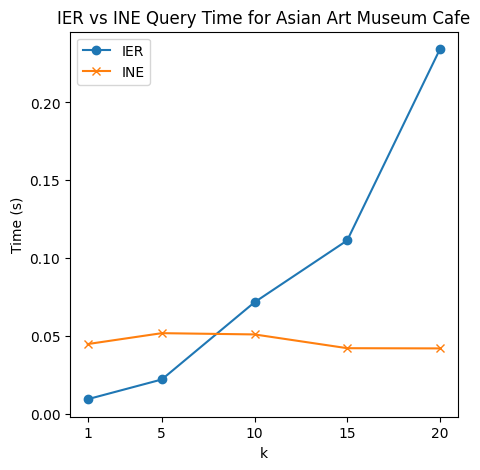

In [186]:
import time

IER_times = []
INE_times = []
k_possible_values = [1, 5, 10, 15, 20]
q = attractions_gdf[attractions_gdf.name=="Asian Art Museum Cafe"].geometry.values[0]

for k in k_possible_values:
    start_time = time.time()
    IER_knn = IER(q, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
    end_time = time.time()
    IER_times.append(end_time - start_time)
    
    start_time = time.time()
    INE_knn = INE(q, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
    end_time = time.time()
    INE_times.append(end_time - start_time)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(k_possible_values, IER_times, label='IER', marker='o')
plt.plot(k_possible_values, INE_times, label='INE', marker='x')
plt.xticks(k_possible_values)
plt.xlabel('k')
plt.ylabel('Time (s)')
plt.title('IER vs INE Query Time for Asian Art Museum Cafe')
plt.legend()
plt.savefig('images/KNN1.png')
plt.show()

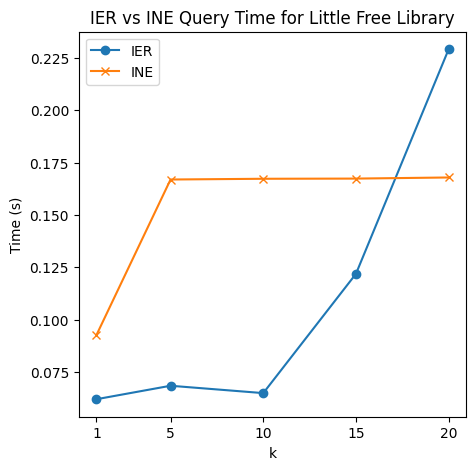

In [191]:
import time

IER_times = []
INE_times = []
k_possible_values = [1, 5, 10, 15, 20]
q = attractions_gdf[attractions_gdf.name=="Little Free Library"].geometry.values[0]

for k in k_possible_values:
    start_time = time.time()
    IER_knn = IER(q, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
    end_time = time.time()
    IER_times.append(end_time - start_time)
    
    start_time = time.time()
    INE_knn = INE(q, k, attractions_gdf, poi_rtree, edges_gdf, polyline_rtree, G)
    end_time = time.time()
    INE_times.append(end_time - start_time)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(k_possible_values, IER_times, label='IER', marker='o')
plt.plot(k_possible_values, INE_times, label='INE', marker='x')
plt.xticks(k_possible_values)
plt.xlabel('k')
plt.ylabel('Time (s)')
plt.title('IER vs INE Query Time for Little Free Library')
plt.legend()
plt.savefig('images/KNN2.png')
plt.show()

## 7- Observations

Are your results aligned with those presented in the paper? Provide a brief summary of your observations below. Include details on any differences or similarities in performance, and discuss any unexpected findings or challenges you encountered during the implementation process.



**TL;DR:** Yes!

**Full Answer:**

The results when experimented with two PoIs from OSM dataset, align overally with the paper. See these figures. The first one is from the paper results on KNN, second one is KNN on "Asian Museum Art Cafe" with latitude and longitude `(37.780067, -122.416053)`, and the third one is KNN on "Little Free Library" with latitude and longitude `(37.779080, -122.448942)`.

<div style="display: flex; justify-content: space-around;">
    <img src="images/KNN_paper.png" alt="Image 1" style="width: 30%;"/>
    <img src="images/KNN1.png" alt="Image 2" style="width: 30%;"/>
    <img src="images/KNN2.png" alt="Image 3" style="width: 30%;"/>
</div>


As the general patterns of figures show, my results follow similar patterns as the paper for IER and INE. More Precisely, we can see that:

- In all three figures IER runtime grows as `k` increases, which complies with the paper result.

- We can see that in our dataset, for small values of `k`, INE takes longer than IER, which contrasts with paper plot. There are several reasons for this observation. 1. Entities from the paper are synthetic generated and does not represent real topological structure of true PoIs in road network. 2. The paper only considers **bidirectional** edges for simplicity, which disturbs true data distribution whereas we consider unidirectional  roads and streets too. 3. In road network and PoIs of San Francisco, `euclidean distance` is a good estimator of `network distance` because PoIs are located near each other with higher density. Namely, in one street we are more likely to find closest PoIs in euclidean distance be also close in network distance. Contrastively, if we perform IER and INE in another less populated city, we will more likely see IER takes longer for small `k` because in those areas, euclidean distance does not approximate network distance.

- For large `k`, `k > 10`, in second and third image, `IER` runtime grows largely, which complies with the outcome from paper.

- The KNN performance is data-driven, meaning that the performance depends on density/sparsity of roads and PoIs distribution. For example, comparing [Asian Museum Art Cafe](images/KNN1.png) (Asian Art Museum Cafe) and [Little Free Library](images/KNN2.png) (Little Free Library), we observe KNN for Asian Art Museum Cafe took less time than Little Free Library for all values of `k`. Particularly for `k=5`, IER for [Asian Museum Art Cafe](images/KNN1.png) takes ~0.02 but IER for [Little Free Library](images/KNN2.png), it takes 0.075s, almost 3.75 times longer! INE for [Asian Museum Art Cafe](images/KNN1.png) takes 0.05s and for [Little Free Library](images/KNN2.png) ~ 0.2s. The two pictures below provides a glance of PoI distributions for Asian Museum Art Cafe and Little Free Library, respectively. There are more POIs around Asian Art Museum than Little Free Library.

<div style="display: flex; justify-content: space-around;">
    <img src="images/Asian Art Museum POI.png" alt="AAM" style="width: 48%;"/>
    <img src="images/Little Free Library.png" alt="LFL" style="width: 48%;"/>
</div>

**Challenges:**
- POIs lie in one road segment: In such settings, `compute_ND` returned 0. To overcome this problem, we projected PoIs on road segment and extracted the sub-line connecting PoIs on road segment's line string. This way, we avoided `network_distance=0` and were able to find KNNs which are compatible with the distance from OSM map.
- `dN < dE`: Although in lecture we learned `dN >=dE` as a property, in implementation of IER and INE, we saw otherwise. The reason is that we project nodes to line segment that covers network nodes (or PoIs) and start calculating the distance from projected node. The real intuition can be described as walking from a PoI to the closest node in the road and drive from the road to destination.